---

# Machine Learning practico con la ayuda de Python
# Capitulo 8: Metodos de Clasificacion

## Aldo Humberto Romero 

### BUAP, Marzo, 2022

---

In [1]:
# commands prefaced by a % in Jupyter are called "magic"
# these "magic" commands allow us to do special things only related to jupyter

# %matplotlib inline - allows one to display charts from the matplotlib library in a notebook
# %load_ext autoreload - automatically reloads imported modules if they change
# %autoreload 2 - automatically reloads imported modules if they change
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext watermark
%watermark

Last updated: 2022-03-27T17:11:41.444212+02:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

In [4]:
%watermark -iv

matplotlib: 3.5.1
sklearn   : 1.0.2
numpy     : 1.21.5



# Donde estamos en el mapa?

<img src="fig/ml_map.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

# Clasificacion 

Clasificacion y regresion son los problemas que dan los fundamentos de muchos de los algoritmos de Machine Learning, en particular para el caso de aprendizaje supervisado. En este caso el problema es identificar a que clase or categoria los nuevos datos pertenecen, una vez el modelo ha sido entrenado, con datos a los que sabemos las etiquetas.

En ML y estadistica, clasificacion es el problema de identificar a cual dentro de un conjunto de categorias (subpoblaciones) pertence una nueva observacion, basados en el hecho que el conjunto de entrenamiento contiene observaciones (o instancias) a las cuales sabemos sus categorias.

El siguiente ejercicion provee una buena introduccion a muchas de los conceptos relevantes de clasificacion, algunos de ellos son validos inclusive cuando nos cambiamos a valores continuos, como es el caso de problemas de regresion.

# Base de datos MNIST

La base de datos MNIST esta compuesta de digitos escritos a mano, disponibles en al link abajo y que tiene como un conjunto de entrenamiento de 60,000 ejemplos y 10,000 para pruebas. Este es un subconjunto de una base de datos mucho mas grande disponible en NIST. Los digitos ha sido estandarizados en tamaño y centrados en el centro de la imagen. Es una muy buena base de datos para personas que quieren practicar conceptos o metodos de ML, en particular con los metodos de reconocimiento de patrones en datos de la vida real, con relativamente poco esfuerzo para el preproceso y formato.

Muchos metodos han sido probados con este conjunto de datos. Para mas informacion acerca de los datos originales de NIST lo pueden ver en [Yann LeCun Website](http://yann.lecun.com/exdb/mnist/)

In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home=".", cache=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

Cada imagen es un vector con 784 component que corresponden a una matrix 28x28

In [8]:
28 * 28

784

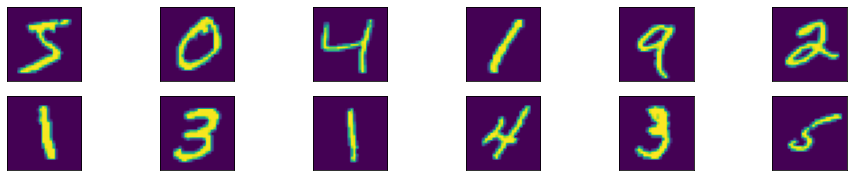

In [9]:
# Number of Rows
rgrid=2
# Number of Columns
cgrid=6

fig, axes = plt.subplots(rgrid,cgrid, figsize=(16,3))
for i in range(rgrid):
    for j in range(cgrid):
        # recuerden que X es un dataframe de pandas
        selected=X.iloc[cgrid*i+j].values
        axes[i,j].imshow(selected.reshape(28,28))
        axes[i,j].xaxis.set_ticks_position('none')
        axes[i,j].yaxis.set_ticks_position('none')
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])

In [10]:
y[:12].values.reshape(2,6)

[['5', '0', '4', '1', '9', '2'], ['1', '3', '1', '4', '3', '5']]
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [11]:
y = y.astype(np.uint8)

In [104]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [90]:
# EXTRA
# Una funcion general que muestre los digitos en una arreglo

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

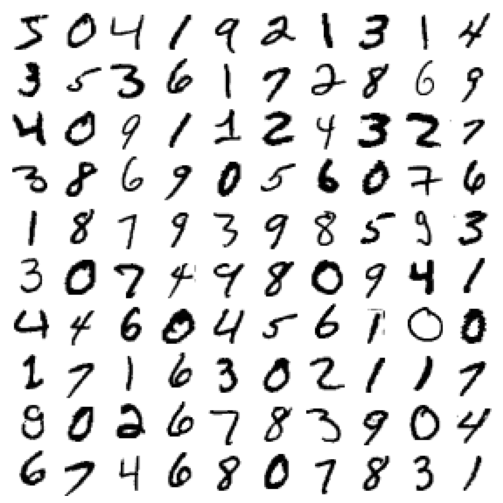

In [14]:
plt.figure(figsize=(9,9))
example_images = X[:100].values
plot_digits(example_images, images_per_row=10)

In [15]:
y[0]

5

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Clasificador Binario

Mas adelante vamos a mirar el problema de clasificar todos los 10 digitos. For ahora nos vamos a enforcar en una clasificacion mas sencillas, vamos a tratar de identificar si numero es el 5 o no.

In [17]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Nota**: algunos ``hiperparametros`` podrian tener diferentes valores en futuros versiones de Scikit-Learn, tales como `max_iter` y `tol`. Para evitar problemas a futuro, vamos a poner los valores de default. 

Como hablamos, hay varios clasificadores implementados en Scikit-Learn, uno de ellos es el que llaman grandiente conjugado estocastico Stochastic gradient descent (SGD) `SGDClassifier`. Es un metodo simple pero eficiente para ajustar un modelo lineal. Mientras que SGC es en realidad un metodo iterativo usado para optimizar la solucion de una funcion objetivo que tiene que tener propiedades "suaves" pero haciendo una camina estocastica. el clasificados de SGD usa este metodo pero ahora con un modelo lineal regularizado. Es particularmente util cuando el numero de muestras (y el numero de "features") es muy grande y por lo tanto no tiene que tener toda la base de datos en RAM/ Este proceso se obtiene siguiente la direccin del gradiente negativo de la funcion objetivo luego de ver uno o un poco de datos de entrenamiento.  

Una muy buena discusion de el SGD se puede encontrar en [SGD site](https://www.geeksforgeeks.org/ml-stochastic-gradient-descent-sgd/), de donde hemos tomado la figura abajo. La del lado izquierdo representa el gradiente de todo el conjunto de datos mientras que el de la derecha es el estocastico, donde se va escogiendo una muestra de manera aleatoria en cada etapa.

<table><tr><td><img src='fig/gdp.png' alt="Batch Gradient Descent" style="width:60%"></td><td><img src='fig/gdp-1.jpg' alt="Stochastic Gradient Descent" style="width:60%"></td></tr></table>
</a>

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [19]:
sgd_clf.predict(X_train[:12])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [20]:
y_train[:12]

0     5
1     0
2     4
3     1
4     9
5     2
6     1
7     3
8     1
9     4
10    3
11    5
Name: class, dtype: uint8

A ojo parece que el clasificador parece estar trabajando bien, pero como podemos cuantificarlo? pues recordamos lo que hablamos en el capitulo pasado.

## Precision

Como hablamos, aqui usaremos la medida de precision, es decir el numero total de respuestas correctas con respecto al numero total de casos.


\begin{equation}
accuracy = \frac{\text{Total number of right answers}}{\text{Total number of cases}}
\end{equation}

Cuando lo hacemos sobre diferentes subconjuntos del conjunto de entrenamiento, esto es lo que se llama **validacion cruzada (cross validation)**

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Sin embargo, podemos engañar al algoritm, por ejemplo creemos un nuevo clasificador que siempre de resultados negativso no importa cual es el vector que ha sido presentado.

In [22]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

COmo ven, llegamos a tener 90% de precision, lop cual es consistente con el hecho que hay un gran numero de datos que "no estan" en la clase requerida.

## Matriz de Confusion

Una mejor manera de mirar el rendimiento de un clasificador es a traves de la matrix de confusion. La matrix que clasifica los resultados de acuerdo a 4 conjuntos:


 * **Verdaderos positivos** Imagenes que son 5 y fueron identificadas como 5
 * **Verdaderos negativos** Imagenes que no son 5 y que fueron identicadas como no 5
 * **Falsos positivos** Imagenenes que NO son 5 pero fueron identificadas como 5
 * **Falsos negativos** Imagenes que son 5 pero que fueron identificadas como no 5

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred = sgd_clf.predict(X_train)

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52316,  2263],
       [  601,  4820]])

Una matriz de confusion perfecta deberia de lucir como:


In [26]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision, Recall and F1

<img src="fig/Precision_Recall.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

Instead of using the **accuracy** a better metric could be use the precision and recall as defined by:

\begin{equation}
precision = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
\end{equation}

---

\begin{equation}
recall = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
\end{equation}

Finally there is one metric that measures the balance between precision and recall

\begin{equation}
F_1 = \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
\end{equation}


In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.6805026118876183

In [28]:
# TP = 4820
# FP = 2263
4820 / (4820 + 2263)

0.6805026118876183

In [29]:
recall_score(y_train_5, y_train_pred)

0.8891348459693783

In [30]:
# TP = 4820
# FN = 601
4820 / (4820 + 601)

0.8891348459693783

In [31]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7709532949456175

In [32]:
4820 / (4820 + (601 + 2263) / 2)

0.7709532949456174

### Funcion de Decision 

Scikit-learn provee una funcion que muestra que SGD asigno para cada conjunto de inputs. Por ejemplo los primeros 12 son

In [33]:
y_scores = sgd_clf.decision_function(X_train[:12])
y_scores

array([  2164.22030239,  -5897.37359354, -13489.14805779,  -4623.84515943,
        -6873.05248453,  -3908.27576291,  -4851.9422397 ,  -4988.52407755,
        -2226.78132866,  -4081.33692831,  -5711.47789687,   4742.52813158])

Note que las imagenes identificadas con 5 reciben un resultado positivio y los otros numeros reciben resultados negativos. 

In [34]:
y_train[:12]

0     5
1     0
2     4
3     1
4     9
5     2
6     1
7     3
8     1
9     4
10    3
11    5
Name: class, dtype: uint8

## Cambiando el umbral

Vale la pena observar que si por alguna razon nosotros pudieramos cambiar el umbral de aceptacion para considerar una imagen como un 5, esto incrementaria la precision (porque reduce el FP) pero al costo de reducir el "recall" (a su vez incrementando FN). EN resumen, precision y recall son dos cantidades que se "pelean entre ellas".

EN otras palabras, miremos el problema de clasificacion desde otra perspectiva. Lo que vamos es a mirar las probabilidades de cada clase. La razon de porque puede ser bueno hacerlo asi es porque nos da una capacidad de escoger e inclusive calibrar el umbrarl de como vamos a interpretar las probabilidades predichas. 


Por ejemplo, el default de un modelo puede tener un umbral de 0.5 (si esta entre 0->0.49 tiene un resultado negativo y si tiene de 0.5->1.0 es positivo). Pero el umbral se puede ajustar para mejorar el resultado del modelo.


In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [36]:
y_some_digit_pred

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [37]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

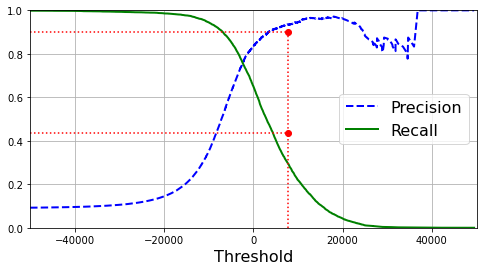

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown


In [41]:
(y_train_pred == (y_scores > 0)).all()

False

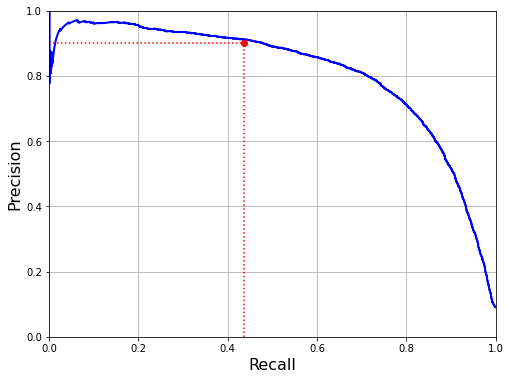

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro");

In [43]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [44]:
threshold_90_precision

3370.0194991439557

In [45]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [46]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [47]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# Curvas ROC


Las curvas denominadas Operacion caracteristica de recepcion (Receiver Operating Characteristic, ROC) es una grafica de "recall" (tambien llamada de *True Positive Rate*) en contra de las tambien False Positive Rate (FPR), es decir que uno menos True Negative Rate (TNR) (resultados negativsop que realmente eran negativos).

Es decir, ROC es una grafica que mide el rendimiento de un modelo de clasificacion considerando todos los umbrales de clasificacion. Como vimos tiene realmente dos parametros la tasa de positivos  y la tasa de negativos. Por lo tanto, es una grafica de los falsos positivos (eje-x) contra los verdaderos positivos (eje-y) para un numero de diferentes umbrales entre 0 y 1.

 is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:


Por lo tanto

 * FPR = 1 - TNR = 1 - specificity
 * TPR = Recall = sensitivity
 

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

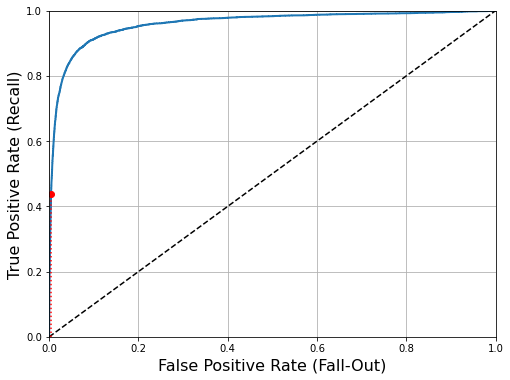

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown

AUC es el area bajo la curva ROC. Nos da una medida agregada del rendimiento a lo largo de todos los posibles umbrales de clasificacion. Mide de alguna manera la probabilidad que el modelo posicione un ejemplo positivo aleatorio mas arriba que un ejemplo negativo aleatorio. 

In [50]:

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Nota**: Definimos `n_estimators=100` por si el default cambien el futuro en Scikit-Learn.

In [51]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [52]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

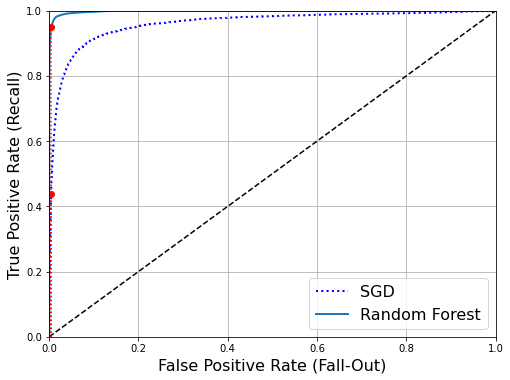

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [55]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [56]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

La forma de la curva contiene bastante informacion.

Valores pequeños en el eje-x de la grafica indicar falso positivos en menos porcentaje y verdaderos negativos mas altos. Valores grandes en el eje-y indican una mas alto porcentaje de verdaderos positivos y mas bajos de falsos negativos. Recuerde que aqui es una respuesta binaria, o la prediccion es correcta (verdadero positivo) o no (falso  positivo). Estas dos cantidades se pelean entre si (de la misma manera verdaderos negativos y falsos negativos).

Un buen modelo asigna probabilidades mas altas a una ocurrencia real positiva que a una ocurrencia negativa en promedio. Por lo tanto un buen modelo esta representado por curvas que se curvan en el lado izquierdo/alto de la grafica. Un modelo no tan bueno es aquel que no puede discriminar entre las clases y prediciria una clase aleatoria o una misma clase en todos los casos (un punto en 0.5, 0.5) Un usuario puede graficar las curvas ROC para el modelo final y escoger el umbral que da un balance deseado entre los falsos positivos y los falsos negativos. 

**Nota**: el uso de las curvas ROC y de precision/recall es usualmente:
 - Curvas ROC deberian de usarse cuando hay mas o menos un mismo numero de observaciones en cada clase
 
 - Curvas Precision-Recall deberian de usarse cuando hay imbalance de datos en las clases.


# Clasificacion de Multiclases

Hasta lo que hemos visto es solo para un clasificado binario, pero en realidad el MNIST es realmente un problem de clasificacion de multi-clase. Por lo tanto el objetivo es construir una funcion que, dado un numero dato, prediga correctamente la clase a la que el nuevo dato pertenece.

Hay diferentes clasificadores multiclase en Scikit-Learn. Algunos son solo binarios (que se puede usar como uno-contra todos, o uno-uno) y otros son realmente multiclases, como es el caso de KNN, decision trees, neural networks, logistic regression, Naive Bayes, SVM, etc. 

El mas simple de todos es el denominado OVA (one vs all), que basicamente trata la clasificacion multiclase como un conjunto de clasificaciones binarias. EN este caso entrenamos cada clasificador binario independientemente. Un ejemplo simple se ve en la figura del lado izquierdo abajo. Cada figura corresponde a una sola clase.
 

Nota: dependiendo ce omo el clasificado binario es definido, hay una probabilidad que se consigan resultados contradictorios, especialmente si los datos que tienes no son balanceados. Si esto sucede, es una buena idea usar funciones discriminatorias o usar una funcion de perdida o error (loss function). Una buena introduccion a esta idea la pueden encontrar en [Loss function description](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23).

La otra posibilidad es usar una clasificacion 1-1, que basicamente considera todos los posible pares, como se ve en el centro de la figura. Aqui el beneficio es que el conjunto de datos usado para entrenar es mas pequeño, pero hay un numero mas grade de clasificadores. Sin embargo, aunque parece que se tiene que hacer mas trabajo, no es el caso, porque cada clasificador es mas pequeño, lo que se puede entonces paralelizar.

Otro metodo es el llamado **error al corregir codigo de salida** (**error correcting output codes**, ECOC) y que es uno de los metodos mas usados hoy en dia. Es realmente un metodo de conjuntos (ensembles). Este meotod lo que hare es convertir un problema de multi-clases como un problema multiple de clasificaciones binarias, usando los modelos de clasificacion binaria conocidos. A diferencia de los metodos anteriores, ECOC permida que cada clase puede estar "codificada" es un numero arbitrario de problemas de clasificacion binaria. Es decir cada clase este codificada por una cadena de bits (bitstring). Cada bit puede ser predicho por un problema de clasificacion binaria. El numero de bits es arbitrario pero se sugiere que sea mas grande que el numero de clases.

    

Cada modelo recibe la misma entrada pero solo predice una posicion en el "bitstring". En el entrenamiento, cada modelos puede ser entreado para producir el valor correcto 0 o 1 de la tarea binaria. Con nuevo dato, se usan todos los modelos y luego se mira cual es el mas cercano.



Primero, uno matrix de codigo es creada, que es una representacion binaria de cada una de las clases, cada codigo es diferente para cada clase y la representacion binaria es tambien llamada palabra clave (codeword). EL siguiente paso es usar algoritmos de clasificacion binaria sobre los mismos datos, donde cada salida es un valor binario. Estos algorimos de clasificacion binaria se llaman aprendizes. Por lo tanto cada nuevo intento es evaluado a travez de los aprendices. Entre mayor sea el numero de aprendices mejor.


<table><tr><td><img src='fig/MultiClassClassification_1.jpeg' alt="OtoA" style="width:90%"></td><td><img src='fig/MultiClassClassification_2.jpeg' alt="OtoO" style="width:90%"></td><td><img src='fig/MultiClassClassification_3.jpeg' alt="ECOC" style="width:90%"></td></tr></table>


En el siguiente ejemplo usamos SVM como el clasificador de nuestros datos en 10 dimensiones. EN SVM es pueden usar diferentes separadors, aqui vamos a usar el mas simple que es el **linear kernel**, mas info la pueden encontrar en 
[Scikit SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). 




Antes de comenzar dejenme introducir un concepto que vamos a usar abajo y que tiene que ver con un concepto muy usado en ML

### Regularizacion


Uno de los problemas tipicos en ML se llama "overfitting". Esto se ve cuando el modelo tiene un rendimiento muy alto con los datos de entrenamiento pero no es capaz de predecir los datos de prueba (test). 

<img src="fig/Overfitting.png" width="700" height="200" title="Overfitting" alt="Overfitting"></a>

Como matematicamente medimos que tan bien o que tan mal estamos? pues definimos una funcion de error

$$
\mathcal{L} = \sum_i f(y_i,\hat{y}_i) 
$$

Donde $f(a,b)$ es una funcion que mide que tan diference es la prediccion del resultado esperado (usualmente se usa una metrica bien definida, por ejemplo, $f(a,b)=\sqrt{(a-b)^2}$. 

Lo que hace regularization es penalizar algunos de los coeficientes que usamos en el modelo. 

Hay varios metodos de regularizacion. Algunos son

+ El llamado $l2$, $\text{Funcion de costo} = \mathcal{L}  + \frac{\lambda}{2m} \sum_i ||w_i||^2$

+ El llamado $l1$, $\text{Funcion de costo} = \mathcal{L}  + \frac{\lambda}{2m} \sum_i ||w_i||$

Cuando hablemos de NN, volveremos a este tema.

In [86]:
from sklearn.svm import SVC

# De acuerdo al manual: The multiclass support is handled according to a one-vs-one scheme
# De acuerdo al manual:
# the gamma parameter defines how far the influence of a single training example reaches, 
# with low values meaning ‘far’ and high values meaning ‘close’. 
# The gamma parameters can be seen as the inverse of the radius of influence of samples selected by 
# the model as support vectors.

svm_clf = SVC(gamma="auto", random_state=42)
print(X_train.shape, X_test.shape)
print(X_train[:1000].shape)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict(X_train[:12])

(60000, 784) (10000, 784)
(1000, 784)


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [59]:
y_train[:12]

0     5
1     0
2     4
3     1
4     9
5     2
6     1
7     3
8     1
9     4
10    3
11    5
Name: class, dtype: uint8

In [87]:
# Evaluate the decision function for the samples in X_train (n_samples, n_features)
print(X_train[:1].shape)
# Pasando solo una imagen y con esto sabremos los diferentes scores para cada clase
scores_for_5 = svm_clf.decision_function(X_train[:1])
scores_for_5

(1, 784)


array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [61]:
np.argmax(scores_for_5)

5

In [62]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [78]:
print(svm_clf.classes_[5],svm_clf.classes_[2])


5 2


In [88]:
# One-vs-the-rest (OvR) multiclass strategy
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [89]:
len(ovr_clf.estimators_)

10

In [66]:
# Linear classifiers (SVM, logistic regression, etc.) with SGD training.
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [67]:
sgd_clf.predict(X_train[:12])

array([3, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [68]:
sgd_clf.decision_function(X_train[:1])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [69]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [70]:
# Standardize features by removing the mean and scaling to unit variance
# The standard score of a sample x is calculated as:
# z = (x - u) / s

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv=3, scoring="accuracy")

array([0.84431138, 0.81381381, 0.77177177])

In [71]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:1000], 
                                 y_train[:1000], cv=3)
conf_mx = confusion_matrix(y_train[:1000], y_train_pred[:1000])
conf_mx

array([[ 88,   0,   0,   0,   0,   7,   2,   0,   0,   0],
       [  1, 100,   3,   0,   0,   4,   0,   1,   5,   2],
       [  2,   3,  73,   3,   2,   3,   3,   4,   5,   1],
       [  0,   1,   7,  74,   1,   5,   0,   2,   0,   3],
       [  1,   0,   1,   2,  85,   4,   2,   1,   2,   7],
       [  0,   2,   2,   9,   4,  65,   1,   1,   6,   2],
       [  2,   2,   3,   0,   2,   4,  81,   0,   0,   0],
       [  0,   0,   2,   1,   4,   0,   0, 104,   0,   6],
       [  0,   4,   2,   0,   0,   6,   2,   1,  70,   2],
       [  5,   0,   0,   1,   5,   1,   0,  17,   1,  70]])

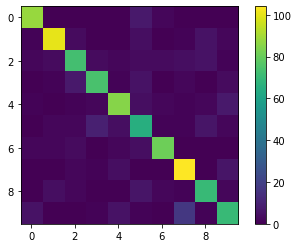

In [72]:
plt.imshow(conf_mx)
plt.colorbar();

In [73]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

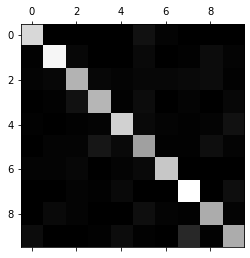

In [74]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [75]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

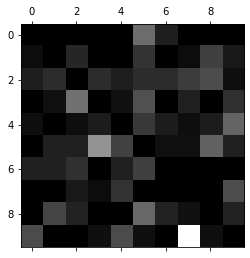

In [76]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

/Users/aldoromero/.local/lib/python3.9/site-packages/scikit_learn-1.0.2-py3.9-macosx-11.0-arm64.egg/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


(147, 784)


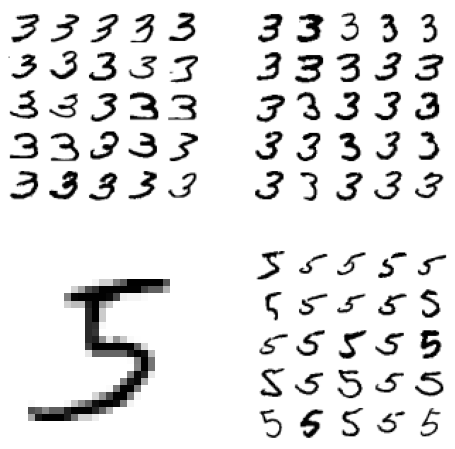

In [91]:
y_train_pred = sgd_clf.predict(X_train_scaled)

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

print(X_aa.shape)
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25].values, images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25].values, images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25].values, images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25].values, images_per_row=5)

# Clasificacion de multietiqueta

In [92]:
# Dos classificaciones, mas grande que 7 o si es par o impar 

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [93]:
knn_clf.predict(X_train[:4])

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True]])

**OJO**: La siguiente celda puede tomar mucho tiempo the following cell may take a very long time (possibly hours depending on your hardware).

In [97]:
y_train_knn_pred = knn_clf.predict(X_train[:100])
f1_score(y_multilabel[:100], y_train_knn_pred, average="macro")

0.9862775751259336

# Multioutput classification

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [132]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test.to_numpy() + noise
print(X_test_mod.shape)
print(type(X_test_mod[0,:]))
y_train_mod = X_train.to_numpy()
y_test_mod = X_test.to_numpy()

(10000, 784)
<class 'numpy.ndarray'>



(784,)


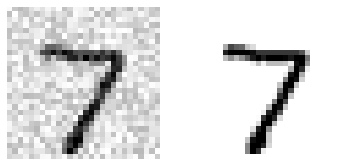

In [133]:
some_index = 0
print()
print(X_test_mod[0].shape)
plt.subplot(121); plot_digit(X_test_mod[some_index,:])
plt.subplot(122); plot_digit(y_test_mod[some_index,:])

/Users/aldoromero/.local/lib/python3.9/site-packages/scikit_learn-1.0.2-py3.9-macosx-11.0-arm64.egg/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


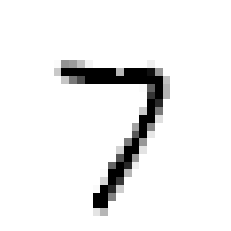

In [134]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)